In [1]:
import matplotlib.pyplot as plt
import numpy as np

import json, os, re
from collections import defaultdict
from itertools import cycle, islice

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Analysis of precision and recall values for different pattern sets

## Visualization ideas
- spamogram with correct and incorrect matches visible

The following patterns, generated by Rasbhari, have been used (number after `w` is weight, after `d` is number of don't care positions:


In [2]:
!ls ../pattern_sets/data/

w-3_d-3.out  w-4_d-4.out   w-5_d-11.out  w-5_d-8.out   w-7_d-3.out  w-7_d-9.out
w-3_d-4.out  w-4_d-5.out   w-5_d-3.out	 w-5_d-9.out   w-7_d-4.out
w-3_d-5.out  w-4_d-6.out   w-5_d-4.out	 w-7_d-10.out  w-7_d-5.out
w-3_d-6.out  w-4_d-7.out   w-5_d-5.out	 w-7_d-11.out  w-7_d-6.out
w-3_d-7.out  w-4_d-8.out   w-5_d-6.out	 w-7_d-12.out  w-7_d-7.out
w-4_d-3.out  w-5_d-10.out  w-5_d-7.out	 w-7_d-13.out  w-7_d-8.out


In [3]:
data = defaultdict(lambda: defaultdict(dict))
for file in os.listdir('../stats-out-modified-cb/'):
    if file.startswith('RV'):
        directory = file
    else:
        continue
    for file in os.listdir(directory):
        match = re.search('(\d+)[^\d]*(\d+)', file)
        weight = match[1]
        dont_care = match[2]
        with open(f'{directory}/{file}') as f:
            data[directory][int(weight)][int(dont_care)] = json.load(f)

In [4]:
def flatten(nested_list):
    return [item for sublist in nested_list for item in sublist]

def unzip(zipped_data):
    return list(zip(*zipped_data))

def extract_prec_rec(data):
    return [(item['precision'], item['recall']) for item in data]



In [5]:
rv20 = data['RV20']

In [6]:
prec_rec = defaultdict(list)
for name, category in data.items():
    for by_weight in category.values():
        for evaluation in by_weight.values():
            for item in evaluation['results']:
                prec_rec[name].append((item['precision'], item['recall']))
prec_rec = sorted(prec_rec.items(), key= lambda el: el[0])

In [7]:
f_scores = []
for name, category in data.items():
    if name != 'RV20':
        continue
    for weight, weight_data in category.items():
        for dont_care, evaluation in weight_data.items():
            for item in evaluation['results']:
                prec = item['precision']
                rec = item['recall']
                prec = 0 if prec is None else prec
                rec = 0 if rec is None else rec
                
                if prec + rec == 0:
                    f_score = 0 
                else:
                    f_score = 2 * prec * rec / (prec + rec)
                    
                f_scores.append((weight, dont_care, f_score))

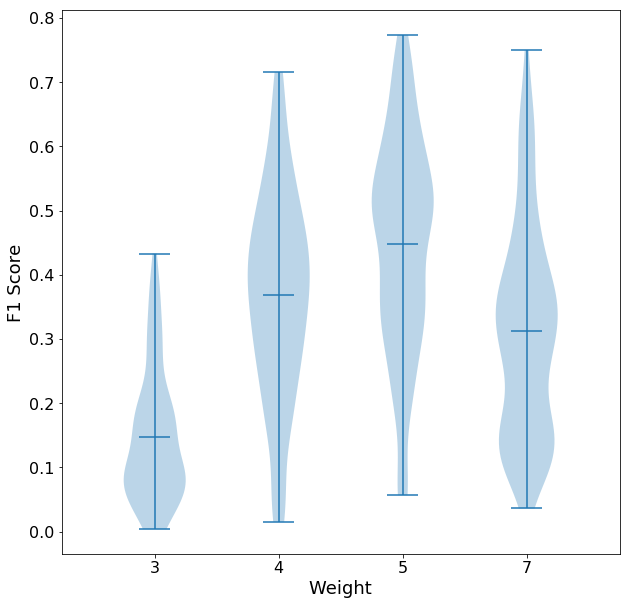

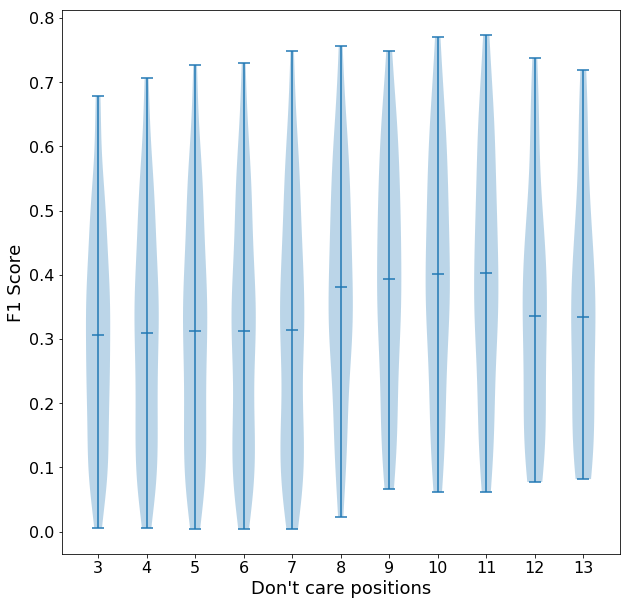

In [8]:
def set_axis_style(ax, labels, x_label='Weight'):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel(x_label)
    ax.set_ylabel('F1 Score')


f_scores_by_weight = defaultdict(list)
f_scores_by_dont_care = defaultdict(list)

for weight, dont_care, f_score in f_scores:
    f_scores_by_weight[weight].append(f_score)
    f_scores_by_dont_care[dont_care].append(f_score)

fig, ax = plt.subplots(figsize=(10,10))
f_scores_by_weight = sorted(f_scores_by_weight.items(), key=lambda el: el[0])
labels, f_score_data = unzip(f_scores_by_weight)
# plt.title('Violin plot of F1 scores by pattern weight')
plt.violinplot(f_score_data, showmeans=True, showextrema=True)
set_axis_style(ax, labels)
plt.savefig('f1-violin')

fig, ax = plt.subplots(figsize=(10,10))
f_scores_by_dont_care = sorted(f_scores_by_dont_care.items(), key=lambda el: el[0])
labels, f_score_data = unzip(f_scores_by_dont_care)
# plt.title('Violin plot of F1 scores by pattern weight')
plt.violinplot(f_score_data, showmeans=True, showextrema=True)
set_axis_style(ax, labels, x_label='Don\'t care positions')
plt.savefig('f1-violin-dont_care')

In [ ]:
## fig, ax = plt.subplots(figsize=(10,10))
colors=iter(plt.cm.rainbow(np.linspace(0,1,len(prec_rec))))
for (category, data), color in islice(zip(prec_rec, colors), 50):
    data = np.asarray(data, dtype='float, float')
    data = np.random.choice(data, len(data) // 1)
    ax.scatter(*unzip(data), marker='+', color=color, label=category)
# plt.title('Precision and recall value pairs for different alignments with \n'\
#           'evaluated with multiple weight/length pattern sets per alignment')
plt.xlabel('Precision')
plt.ylabel('Recall')
ax.legend(title='Reference set', loc='upper right')
plt.savefig('prec-rec-scatter')

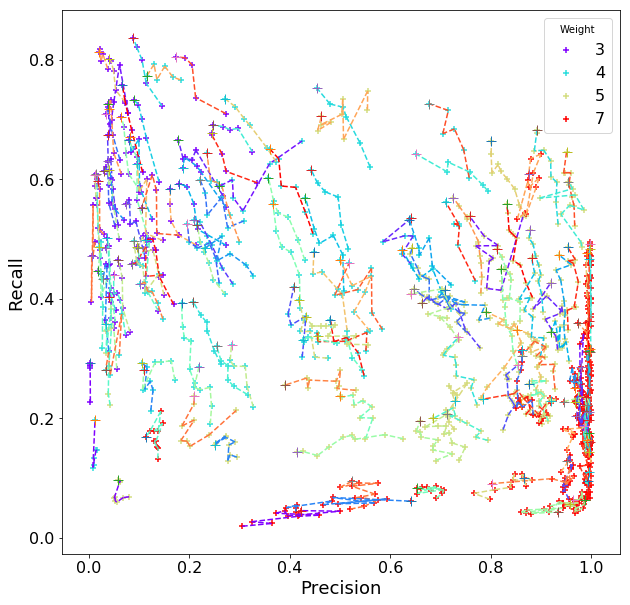

In [10]:
rv20_data = sorted(rv20.items(), key=lambda el: el[0])

fig, ax = plt.subplots(figsize=(10,10))
# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
colors=iter(plt.cm.rainbow(np.linspace(0,1,len(rv20_data))))
for (weight, dont_care_dict), color in islice(zip(rv20_data, colors), 10):
    eval_data = flatten(extract_prec_rec(evaluation['results']) for evaluation in dont_care_dict.values())
    ax.scatter(*unzip(eval_data), marker='+', color=color, label=weight)
    dont_care_data = sorted(dont_care_dict.items(), key=lambda el: el[0])
    line_colors=cycle(iter(plt.cm.rainbow(np.linspace(0,1,len(dont_care_data[0][1]['results'])))))
    
    for ((_, lower_val), (_, higher_val)) in zip(dont_care_data, dont_care_data[1:]):
        for pred, succ, line_color in zip(lower_val['results'], higher_val['results'], line_colors):
            if pred['name'] != succ['name']:
                raise Exception('ERROR')
            plt.plot([pred['precision'], succ['precision']], [pred['recall'], succ['recall']], '--', color=line_color)
    for evaluation in higher_val['results']:
        plt.plot(evaluation['precision'], evaluation['recall'], '+', markersize=10)

# plt.title('Precision recall pairs for RV20 data. Evaluations for same alignment with different lengths (but same weight) are connected by a line.')
plt.xlabel('Precision')
plt.ylabel('Recall')
ax.legend(title='Weight')
plt.savefig('rv20-scatter-connected')

In [11]:
with open('../stats-out-modified-cb/hist-rv20-w-3_d-7.json') as f:
    hist_data_3_7 = json.load(f)
with open('../stats-out-modified-cb/hist-rv20-w-5_d-11.json') as f:
    hist_data_5_11 = json.load(f)
with open('../stats-out-modified-cb/hist-rv20-w-7_d-3.json') as f:
    hist_data_7_3 = json.load(f)
    
titles = [f'RV20 data with pattern set w={w}, d={d}' for w, d in [(3,7), (5, 11), (7, 3)]]

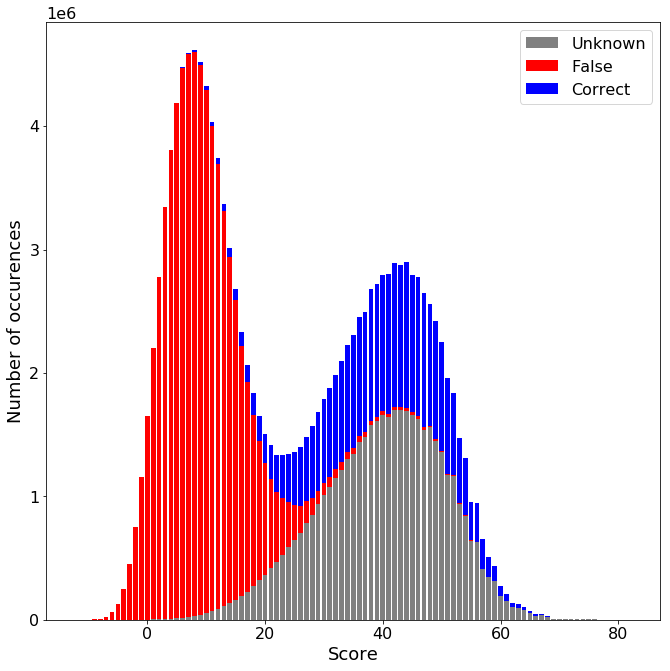

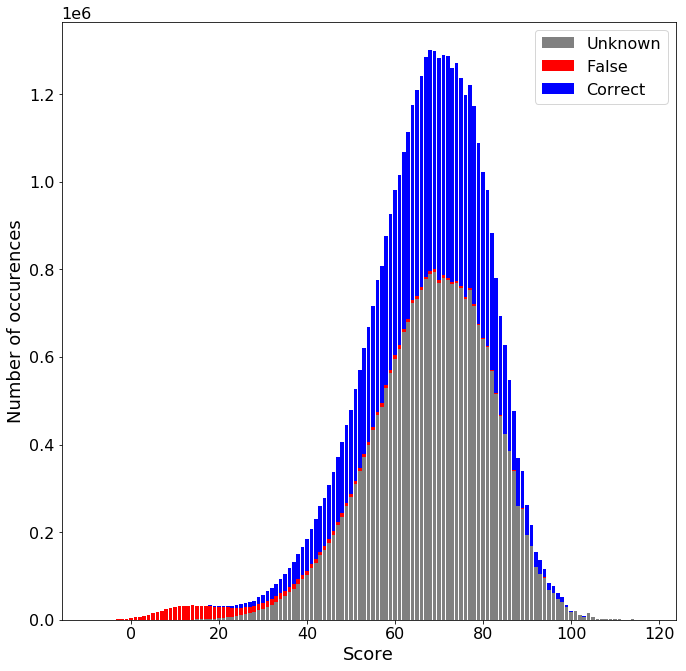

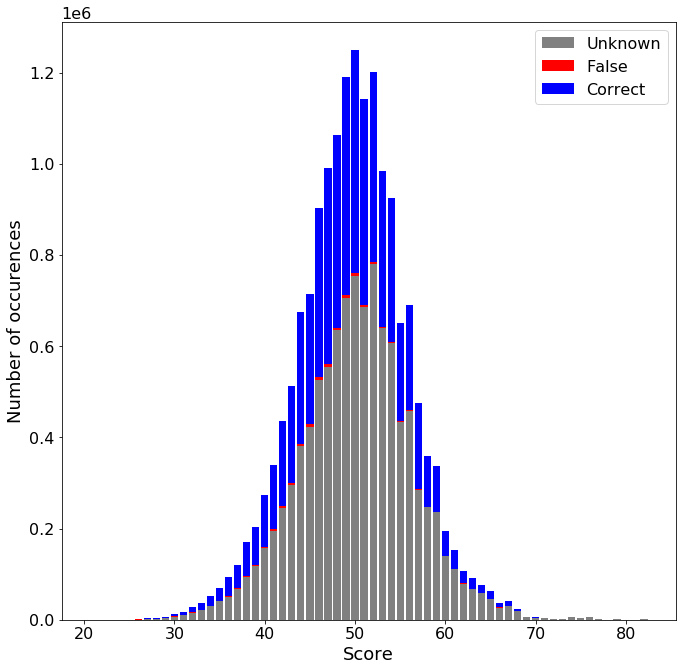

In [17]:
for title, (w, d), hist_data in zip(titles,[(3,7), (5, 11), (7, 3)], [hist_data_3_7, hist_data_5_11, hist_data_7_3]):
    min_score = min(min(int(k) for k in d.keys()) for d in (hist_data['unknown'], hist_data['true_positive'], hist_data['false_positive']))
    max_score = max(max(int(k) for k in d.keys()) for d in (hist_data['unknown'], hist_data['true_positive'], hist_data['false_positive']))

    x_values = np.arange(min_score, max_score+1)
    unknown = np.zeros(np.abs(max_score - min_score) + 1)
    tp = np.zeros(np.abs(max_score - min_score) + 1)
    fp = np.zeros(np.abs(max_score - min_score) + 1)
    for (score, count) in hist_data['unknown'].items():
        unknown[int(score) - min_score] += count
    for (score, count) in hist_data['true_positive'].items():
        tp[int(score) - min_score] += count
    for (score, count) in hist_data['false_positive'].items():
        fp[int(score) - min_score] += count

    plt.figure(figsize=(11,11))
#     plt.title(title)
    plt.xlabel('Score')
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.ylabel('Number of occurences')
    plt.bar(x_values, unknown, color='grey', label='Unknown')
    plt.bar(x_values, fp, bottom=unknown, color='red', label='False')
    plt.bar(x_values, tp, bottom=unknown + fp, color='blue', label='Correct')
    plt.legend()
    plt.savefig(f'w_{w}-d_{d}-hist')